In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nithishm","key":"2d9ef72814a7ac4f083593f1257ff21b"}'}

In [ ]:
!pip install kaggle
#Creating folder named kaggle
!mkdir ~/.kaggle
#copying kaggle.json to folder kaggle
!cp kaggle.json ~/.kaggle/
#Modify file permission to the folder
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/massachusetts-roads-dataset

100% 5.74G/5.76G [00:50<00:00, 137MB/s]
100% 5.76G/5.76G [00:50<00:00, 123MB/s]


In [ ]:
!pip install pyunpack 
!pip install patool

     |████████████████████████████████| 77 kB 3.4 MB/s 


In [ ]:
from pyunpack import Archive
Archive('/content/massachusetts-roads-dataset.zip').extractall("")

In [ ]:
import pandas as pd
import os
from os import path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import random
from tqdm import tqdm


import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path

import json

import numpy as np
import matplotlib.pyplot as plt
import urllib

In [ ]:
#Reading metadata.csv file
meta = pd.read_csv('/content/metadata.csv')

In [ ]:
#Reading label_class_dict.csv file
label = pd.read_csv('/content/label_class_dict.csv')

## EDA

In [ ]:
meta.head(2)

,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,10078660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif,png/train/10078660_15.png,png/train_labels/10078660_15.png
1,10078675_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif,png/train/10078675_15.png,png/train_labels/10078675_15.png


metasdata.csv contains path for images and masks



In [ ]:
label

,name,r,g,b
0,background,0,0,0
1,road,255,255,255


1.   There are 2 classes in the data and they are, 'road' and,  'background'
2.   Their corresponding pixel values are 'road: 255', 'every thing else: 0'



In [ ]:
root_dir='/content'

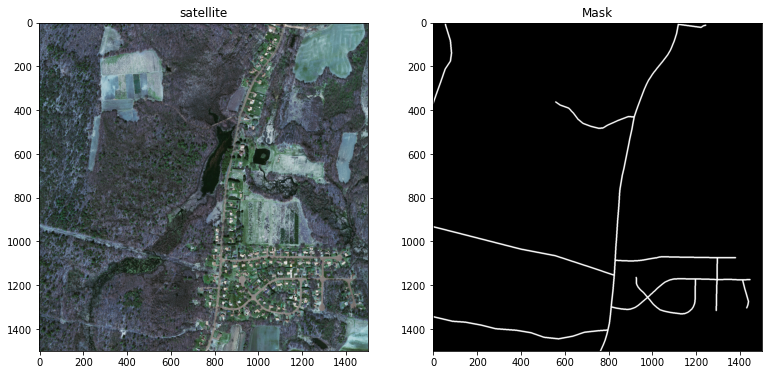

In [ ]:
#Plotting a image whith its mask
img_path = os.path.join(root_dir, meta['tiff_image_path'][1])
mask_path = os.path.join(root_dir, meta['tif_label_path'][1])  
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)
plt.figure(figsize=(20,25))
plt.subplot(131)
plt.title('satellite')
plt.imshow(image)
plt.subplot(132)
plt.title('Mask')
plt.imshow(mask)

1.   Every image is of size 1500*1500 covering a area of 2.5sqkm
2.   Every mask is of size 1500*1500 with road segmented from the original image with a pixel value of 255

In [ ]:
#plotting random images and their masks
for i in range(20):
  rand = random.randint(0,len(meta))
  img_path = os.path.join(root_dir, meta['tiff_image_path'][rand])
  mask_path = os.path.join(root_dir, meta['tif_label_path'][rand])  
  image = cv2.imread(img_path)
  mask = cv2.imread(mask_path)
  plt.figure(figsize=(20,25))
  plt.subplot(131)
  plt.title(img_path)
  plt.imshow(image)
  plt.subplot(132)
  plt.title(mask_path)
  plt.imshow(mask)

Observations - There some images with good chunk of their data missing but thier respective masks have are complete, which might throw of the model.

## Pre-processing

In [ ]:
#Function to store images that are missing less than 10% of size
def preprocess(meta, thereshold):
  complete_image_path=[]
  mask_path=[]
  for i in range(len(meta)):
    img_path = os.path.join(root_dir, meta['tiff_image_path'][i])
    msk_path = os.path.join(root_dir, meta['tif_label_path'][i])
    image = cv2.imread(img_path)
    #converting the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #counting number of white pixels to size of blank part of the image
    if (np.sum(gray_image==255)/(2250000)) <thereshold:
      complete_image_path.append(img_path)
      mask_path.append(msk_path)
  #print(mask_path)
  return(complete_image_path, mask_path)

In [ ]:
image_path, mask_path = preprocess(meta, 0.1)

In [ ]:
print('Number of images with less than 10% of this data missing: ', len(image_path))

Number of images with less than 10% of this data missing:  851


In [ ]:
#plotting random images and their masks after preprocessing
for i in range(10):
  rand = random.randint(0,len(image_path)) 
  image = cv2.imread(image_path[rand])
  mask = cv2.imread(mask_path[rand])
  plt.figure(figsize=(20,25))
  plt.subplot(131)
  plt.title(image_path[rand])
  plt.imshow(image)
  plt.subplot(132)
  plt.title(mask_path[rand])
  plt.imshow(mask)

In [ ]:
def crop_images(image_path, mask_path, directory, crop):
  #Creating new directory
  if os.path.exists(directory):
    print('Directory alredy exists')
  else:
    os.mkdir(directory)
    print("Directory '% s' created" % directory)

  #Creating new directory to store cropped images
  if os.path.exists(directory+'/images'):
    print('Directory alredy exists')
  else:
    os.mkdir(directory+'/images')
    print("Directory '% s'/images created" % directory)

  #Creating new directory to store cropped masks
  if os.path.exists(directory+'/lables'):
    print('Directory alredy exists')
  else:
    os.mkdir(directory+'/lables')
    print("Directory '% s'/lables created" % directory)

  cropped_image_paths = []
  cropped_mask_paths = []

  for i in tqdm(range(len(image_path))):
    image = cv2.imread(image_path[i])
    mask = cv2.imread(mask_path[i])
    a=0
    for j in [0,2,4]:
      for k in [0,2,4]:
        cropped_image_path = directory+'/images/'+str(a)+'_' + image_path[i].split('/')[-1]
        croppped_mask_path = directory+'/lables/'+str(a)+'_' + image_path[i].split('/')[-1]
        a+=1

        cv2.imwrite(cropped_image_path, image[crop[j]:crop[j+1], crop[k]:crop[k+1]])
        cv2.imwrite(croppped_mask_path, mask[crop[j]:crop[j+1], crop[k]:crop[k+1]])

        cropped_image_paths.append(cropped_image_path)
        cropped_mask_paths.append(croppped_mask_path)

  return(cropped_image_paths, cropped_mask_paths)




In [ ]:
crop = [0,512,500,1012,988,1500]
directory = '/content/cropped'

In [ ]:
cropped_images, cropped_masks = crop_images(image_path, mask_path, directory, crop)

Directory '/content/cropped' created
Directory '/content/cropped'/images created
Directory '/content/cropped'/lables created


100%|██████████| 851/851 [03:33<00:00,  4.00it/s]


In [ ]:
len(cropped_images)

7659

In [ ]:
image_path[0]

'/content/tiff/train/10078675_15.tiff'

In [ ]:
#plotting original image and its cropped images

#Original image 1500*1500
image = cv2.imread(image_path[0])
mask = cv2.imread(mask_path[0])
plt.figure(figsize=(20,25))
plt.subplot(121)
plt.title('Original satellite image 1500*1500')
plt.imshow(image)
plt.subplot(122)
plt.title('Original mask 1500*1500')
plt.imshow(mask)

# cropped image 512*512
for i in range(6): 
  image = cv2.imread(cropped_images[i])
  mask = cv2.imread(cropped_masks[i])
  plt.figure(figsize=(12,15))
  plt.subplot(121)
  plt.title('cropped image 512*512')
  plt.imshow(image)
  plt.subplot(122)
  plt.title('cropped mask 512*512')
  plt.imshow(mask)

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# tf.enable_eager_execution()
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(np.array(cropped_images), np.array(cropped_masks), test_size=0.2)

In [ ]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 6.1 MB/s 


In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
class Test_Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['background', 'road']
    
    def __init__(self, image_path, mask_path, classes=CLASSES):
        # the paths of images
        self.images_fps   = image_path
        # the paths of segmentation images
        self.masks_fps    = mask_path
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        #image = image.astype(np.float32)
        image = normalize_image(image)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = mask[:,:,0]
        image_mask[image_mask==0] = 0
        #image_mask[image_mask==255] = 1
        #image_mask = image_mask.astype(np.float32)
        #image_mask = normalize_image(image_mask)

        
        image_masks = [(image_mask == v) for v in [255,0]]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        #image_mask = normalize_image(image_mask)

            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
# Dataset for train images
train_dataset = Dataset(train_images[:], train_masks)
test_dataset  = Test_Dataset(test_images[:], test_masks)

BATCH_SIZE=1
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
#assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
#assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 2)

[0, 1]
(1, 512, 512, 3)


### Augumenting data

In [ ]:
#defining augumentations
aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)
aug3 = iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))
aug4 = iaa.DirectedEdgeDetect(alpha=(0.0, 0.5))

In [ ]:
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['background', 'road']
    
    def __init__(self, image_path, mask_path, classes=CLASSES):
        # the paths of images
        self.images_fps   = image_path
        # the paths of segmentation images
        self.masks_fps    = mask_path
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = normalize_image(image)
        #image = image.astype(np.float32)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        #print(mask)
        image_mask = mask[:,:,0]
        #image_mask[image_mask==0] = 100
        #image_mask = image_mask.astype(np.float32)
        #image_mask = normalize_image(image_mask)

        
        image_masks = [(image_mask == v) for v in [255,0]]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = aug1.augment_image(image)
            image_mask = aug1.augment_image(image_mask)
        elif a<0.4:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.6:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.8:
            image = aug4.augment_image(image)
            image_mask = image_mask

            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
class Test_Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['background', 'road']
    
    def __init__(self, image_path, mask_path, classes=CLASSES):
        # the paths of images
        self.images_fps   = image_path
        # the paths of segmentation images
        self.masks_fps    = mask_path
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = normalize_image(image)
        #image = image.astype(np.float32)
        #image = cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image[0:512, 0:512]
        #img[y:y+h, x:x+w]
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        #mask = cv2.resize(mask,(512,512),interpolation=cv2.INTER_NEAREST)
        #mask = mask[0:512,0:512]
        #print(mask)
        image_mask = mask[:,:,0]
        #image_mask[image_mask==0] = 100
        #image_mask = image_mask.astype(np.float32)
        #image_mask = normalize_image(image_mask)

        
        image_masks = [(image_mask == v) for v in [255,0]]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
# Dataset for train images
train_dataset = Dataset(train_images[:], train_masks)
test_dataset  = Test_Dataset(test_images[:], test_masks)

BATCH_SIZE=1
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 2)

[0, 1]
(1, 512, 512, 3)


## Baseline model

In [ ]:
input_layer = layers.Input(shape=(512,512,3))
x = layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same')(input_layer)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
norm = layers.BatchNormalization(axis=3)(x)
pred = layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.HeNormal())(norm)

In [ ]:

# https://github.com/qubvel/segmentation_models
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.1)

#focal_loss = sm.losses.cce_dice_loss
focal_loss = dice_coef_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss
model = Model(inputs=input_layer,outputs=pred) 

model.compile(optim, focal_loss, metrics=[iou_score])
model.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_138 (Conv2D)         (None, 512, 512, 32)      416       
                                                                 
 conv2d_139 (Conv2D)         (None, 512, 512, 32)      9248      
                                                                 
 conv2d_140 (Conv2D)         (None, 512, 512, 64)      18496     
                                                                 
 conv2d_141 (Conv2D)         (None, 512, 512, 64)      36928     
                                                                 
 conv2d_142 (Conv2D)         (None, 512, 512, 32)      18464     
                                                                 
 conv2d_143 (Conv2D)         (None, 512, 512, 16)      462

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5, validation_data=test_dataloader)

Epoch 1/5
6127/6127 [==============================] - 1045s 171ms/step - loss: 0.5068 - iou_score: 0.5293 - val_loss: 0.5745 - val_iou_score: 0.5135
Epoch 2/5
6127/6127 [==============================] - 1045s 171ms/step - loss: 0.4331 - iou_score: 0.5807 - val_loss: 0.4321 - val_iou_score: 0.5906
Epoch 3/5
6127/6127 [==============================] - 1050s 171ms/step - loss: 0.4010 - iou_score: 0.6028 - val_loss: 0.4118 - val_iou_score: 0.5958
Epoch 4/5
6127/6127 [==============================] - 1054s 172ms/step - loss: 0.3821 - iou_score: 0.6166 - val_loss: 0.3880 - val_iou_score: 0.6129
Epoch 5/5
6127/6127 [==============================] - 1050s 171ms/step - loss: 0.3743 - iou_score: 0.6226 - val_loss: 0.3827 - val_iou_score: 0.6223


In [ ]:
#plotting base models predictions
for i in range(10): 
  image = cv2.imread(test_images[i])
  mask = cv2.imread(test_masks[i])
  pred_mask = model.predict(image[np.newaxis,:,:,:])
  plt.figure(figsize=(12,15))
  plt.subplot(131)
  plt.title('original image')
  plt.imshow(image)
  plt.subplot(132)
  plt.title('original mask')
  plt.imshow(mask)
  plt.subplot(133)
  plt.title('predicted mask')
  plt.imshow(pred_mask[0,:,:,0])

In [ ]:
import pickle
with open('base_model.pkl', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://1d778fc0-79c2-495a-a68c-3cc2f8e707a7/assets


In [ ]:
new_model = keras.models.load_model('/content/content/save/base', {'iou_score':iou_score, 'categorical_crossentropy_plus_dice_loss':focal_loss})

### Augumenting data

In [ ]:
#defining augumentations
aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)
aug3 = iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))
aug4 = iaa.DirectedEdgeDetect(alpha=(0.0, 0.5))

In [ ]:
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['background', 'road']
    
    def __init__(self, image_path, mask_path, classes=CLASSES):
        # the paths of images
        self.images_fps   = image_path
        # the paths of segmentation images
        self.masks_fps    = mask_path
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        #image = image.astype(np.float32)
        image = normalize_image(image)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = mask[:,:,0]
        image_mask[image_mask==0] = 0
        #image_mask[image_mask==255] = 100
        #image_mask = image_mask.astype(np.float32)
        #image_mask = normalize_image(image_mask)

        
        image_masks = [(image_mask == v) for v in [255,0]]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        #image_mask = normalize_image(image_mask)

            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Dataset for train images
train_dataset = Dataset(train_images[:], train_masks)
test_dataset  = Test_Dataset(test_images[:], test_masks)

BATCH_SIZE=1
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 2)

[0, 1]
(1, 512, 512, 3)


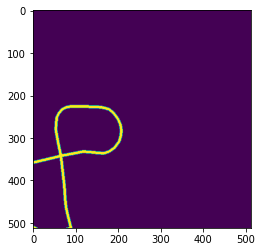

In [ ]:
plt.imshow(train_dataloader[0][1][0,:,:,0])

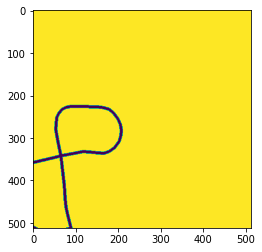

In [ ]:
plt.imshow(train_dataloader[0][1][0,:,:,1])

###Custom-Unet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate,BatchNormalization, Activation, Dropout
#reference https://github.com/zhixuhao/unet/blob/master/model.py

input_layer = layers.Input(shape=(512,512,3))
x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
block_1_out = Activation('relu')(x)
x = MaxPooling2D()(block_1_out)
x = Dropout(0.2)(x)

# Block 2
x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
block_2_out = Activation('relu')(x)
x = MaxPooling2D()(block_2_out)
x = Dropout(0.2)(x)

# Block 3
x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
block_3_out = Activation('relu')(x)
x = MaxPooling2D()(block_3_out)
x = Dropout(0.2)(x)

# Block 4
x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

block_4_out = Activation('relu')(x)

x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_3_out])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# UP 3
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_2_out])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# UP 4
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_1_out])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
pred = Conv2D(2, (3, 3), activation='softmax', padding='same')(x)

model = Model(inputs=[input_layer], outputs=[pred])

In [ ]:
# https://github.com/qubvel/segmentation_models
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss
#focal_loss = dice_coef_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])
#model.summary()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=1)
]

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 512, 512, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [ ]:
model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=1, validation_data=test_dataloader, callbacks = [callbacks])

6127/6127 [==============================] - 1810s 295ms/step - loss: 0.2341 - iou_score: 0.7415 - val_loss: 0.2458 - val_iou_score: 0.7339 - lr: 1.0000e-04


In [ ]:
model.save('model1/unet_10mil',save_format='tf')

INFO:tensorflow:Assets written to: model1/unet_10mil/assets


In [ ]:
import shutil
shutil.make_archive('unet10mil', 'zip', '/content/model1/unet_10mil')

'/content/unet10mil.zip'

In [ ]:
#plotting base models predictions
for i in range(10, 20): 
  image = cv2.imread(test_images[i])
  image = image/255
  mask = cv2.imread(test_masks[i])
  pred_mask = model.predict(image[np.newaxis,:,:,:])
  plt.figure(figsize=(12,15))
  plt.subplot(131)
  plt.title('original image')
  plt.imshow(image)
  plt.subplot(132)
  plt.title('original mask')
  plt.imshow(mask)
  plt.subplot(133)
  plt.title('predicted mask')
  plt.imshow(pred_mask[0,:,:,0])

In [ ]:
for i in range(10, 20): 
  print(test_images[i], test_masks[i])
  

/content/cropped/images/1_24329230_15.tiff /content/cropped/lables/1_24329230_15.tiff
/content/cropped/images/2_24478810_15.tiff /content/cropped/lables/2_24478810_15.tiff
/content/cropped/images/0_24929230_15.tiff /content/cropped/lables/0_24929230_15.tiff
/content/cropped/images/6_22528990_15.tiff /content/cropped/lables/6_22528990_15.tiff
/content/cropped/images/6_15928855_15.tiff /content/cropped/lables/6_15928855_15.tiff
/content/cropped/images/6_24328780_15.tiff /content/cropped/lables/6_24328780_15.tiff
/content/cropped/images/0_22528900_15.tiff /content/cropped/lables/0_22528900_15.tiff
/content/cropped/images/5_21028945_15.tiff /content/cropped/lables/5_21028945_15.tiff
/content/cropped/images/7_11428705_15.tiff /content/cropped/lables/7_11428705_15.tiff
/content/cropped/images/1_22529065_15.tiff /content/cropped/lables/1_22529065_15.tiff


### U-net with resnet34 as encoder

In [ ]:
!pip install -U segmentation-models

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
resnet34 = Unet('resnet34', encoder_weights='imagenet', classes=2, activation='softmax', input_shape=(512,512,3), encoder_freeze = True)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=1)
]

In [ ]:
# https://github.com/qubvel/segmentation_models
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.01)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

resnet34.compile(optim, focal_loss, metrics=[iou_score] )

In [ ]:
history = resnet34.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10, validation_data=test_dataloader, callbacks=[callbacks])

Epoch 1/10
6127/6127 [==============================] - 516s 84ms/step - loss: 0.2913 - iou_score: 0.6968 - val_loss: 0.3197 - val_iou_score: 0.6834 - lr: 0.0100
Epoch 2/10
6127/6127 [==============================] - 513s 84ms/step - loss: 0.2537 - iou_score: 0.7287 - val_loss: 0.3027 - val_iou_score: 0.6924 - lr: 0.0100
Epoch 3/10
6127/6127 [==============================] - 513s 84ms/step - loss: 0.2275 - iou_score: 0.7490 - val_loss: 0.2930 - val_iou_score: 0.6983 - lr: 1.0000e-03
Epoch 4/10
6127/6127 [==============================] - 510s 83ms/step - loss: 0.2251 - iou_score: 0.7508 - val_loss: 0.2883 - val_iou_score: 0.7008 - lr: 1.0000e-04
Epoch 5/10
6127/6127 [==============================] - 511s 83ms/step - loss: 0.2239 - iou_score: 0.7517 - val_loss: 0.2859 - val_iou_score: 0.7043 - lr: 1.0000e-05
Epoch 6/10
6127/6127 [==============================] - 511s 83ms/step - loss: 0.2245 - iou_score: 0.7521 - val_loss: 0.2871 - val_iou_score: 0.7018 - lr: 1.0000e-06
Epoch 7/10
6

In [ ]:
'''pred_masks = [(pred_mask[0,:,:,0]) for v in range(3)]
image_mask = np.stack(pred_masks, axis=-1).astype('float')'''

In [ ]:
resnet34.save('model/resnet34',save_format='tf')

INFO:tensorflow:Assets written to: model/resnet34/assets


In [ ]:
import shutil
shutil.make_archive('resnet34', 'zip', '/content/model/resnet34')

'/content/resnet34.zip'

In [ ]:
#plotting resnet34_Unet models predictions
for i in range(10): 
  image = cv2.imread(test_images[i])
  mask = cv2.imread(test_masks[i])
  pred_mask = resnet34.predict(image[np.newaxis,:,:,:])
  plt.figure(figsize=(12,15))
  plt.subplot(131)
  plt.title('original image')
  plt.imshow(image)
  plt.subplot(132)
  plt.title('original mask')
  plt.imshow(mask)
  plt.subplot(133)
  plt.title('predicted mask')
  plt.imshow(pred_mask[0,:,:,0])

In [ ]:
for i in range(10): 
  print(test_images[i])

/content/cropped/images/4_11128900_15.tiff
/content/cropped/images/2_17878795_15.tiff
/content/cropped/images/2_20878915_15.tiff
/content/cropped/images/6_17728870_15.tiff
/content/cropped/images/5_21629005_15.tiff
/content/cropped/images/2_16978915_15.tiff
/content/cropped/images/5_23728945_15.tiff
/content/cropped/images/8_11578690_15.tiff
/content/cropped/images/0_21328900_15.tiff
/content/cropped/images/7_22828930_15.tiff


### densenet121 as backbone

In [ ]:
!pip install -U segmentation-models

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
densenet121 = Unet('densenet121', encoder_weights='imagenet', classes=2, activation='softmax', input_shape=(512,512,3), encoder_freeze = True)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=1)
]

In [ ]:
# https://github.com/qubvel/segmentation_models
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.01)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

densenet121.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
densenet121.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=6, validation_data=test_dataloader, callbacks=[callbacks])

Epoch 1/6
6127/6127 [==============================] - 707s 113ms/step - loss: 0.2923 - iou_score: 0.6963 - val_loss: 0.3003 - val_iou_score: 0.6848 - lr: 0.0100
Epoch 2/6
6127/6127 [==============================] - 688s 112ms/step - loss: 0.2509 - iou_score: 0.7319 - val_loss: 0.2855 - val_iou_score: 0.7018 - lr: 0.0100
Epoch 3/6
6127/6127 [==============================] - 687s 112ms/step - loss: 0.2265 - iou_score: 0.7517 - val_loss: 0.2667 - val_iou_score: 0.7131 - lr: 1.0000e-03
Epoch 4/6
6127/6127 [==============================] - 687s 112ms/step - loss: 0.2219 - iou_score: 0.7537 - val_loss: 0.2777 - val_iou_score: 0.7044 - lr: 1.0000e-04
Epoch 5/6
6127/6127 [==============================] - 687s 112ms/step - loss: 0.2207 - iou_score: 0.7562 - val_loss: 0.2692 - val_iou_score: 0.7100 - lr: 1.0000e-05
Epoch 6/6
6127/6127 [==============================] - 689s 112ms/step - loss: 0.2220 - iou_score: 0.7531 - val_loss: 0.2702 - val_iou_score: 0.7101 - lr: 1.0000e-06


In [ ]:
'''pred_masks = [(pred_mask[0,:,:,0]) for v in range(3)]
image_mask = np.stack(pred_masks, axis=-1).astype('float')'''

In [ ]:
densenet121.save('unets/densenet121',save_format='tf')

INFO:tensorflow:Assets written to: unets/densenet121/assets


In [ ]:
import shutil
shutil.make_archive('densenet121', 'zip', '/content/unets/densenet121')

'/content/densenet121.zip'

In [ ]:
#plotting resnet34_Unet models predictions
for i in range(10): 
  image = cv2.imread(test_images[i])
  mask = cv2.imread(test_masks[i])
  pred_mask = densenet121.predict(image[np.newaxis,:,:,:])
  plt.figure(figsize=(12,15))
  plt.subplot(131)
  plt.title('original image')
  plt.imshow(image)
  plt.subplot(132)
  plt.title('original mask')
  plt.imshow(mask)
  plt.subplot(133)
  plt.title('predicted mask')
  plt.imshow(pred_mask[0,:,:,0])

In [ ]:
for i in range(10): 
  print(test_images[i])

/content/cropped/images/4_11128900_15.tiff
/content/cropped/images/2_17878795_15.tiff
/content/cropped/images/2_20878915_15.tiff
/content/cropped/images/6_17728870_15.tiff
/content/cropped/images/5_21629005_15.tiff
/content/cropped/images/2_16978915_15.tiff
/content/cropped/images/5_23728945_15.tiff
/content/cropped/images/8_11578690_15.tiff
/content/cropped/images/0_21328900_15.tiff
/content/cropped/images/7_22828930_15.tiff


### U-net with vgg19 as encoder

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
vgg19 = Unet('vgg19', encoder_weights='imagenet', classes=2, activation='softmax', input_shape=(512,512,3), encoder_freeze = True)

80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=1)
]

In [ ]:
# https://github.com/qubvel/segmentation_models
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.01)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

vgg19.compile(optim, focal_loss, metrics=[iou_score] )

In [ ]:
vgg19.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=8, validation_data=test_dataloader, callbacks=[callbacks])

Epoch 1/8
6127/6127 [==============================] - 630s 103ms/step - loss: 0.2819 - iou_score: 0.7028 - val_loss: 0.3092 - val_iou_score: 0.6699 - lr: 0.0100
Epoch 2/8
6127/6127 [==============================] - 625s 102ms/step - loss: 0.2621 - iou_score: 0.7189 - val_loss: 0.3092 - val_iou_score: 0.6802 - lr: 0.0100
Epoch 3/8
6127/6127 [==============================] - 624s 102ms/step - loss: 0.2376 - iou_score: 0.7366 - val_loss: 0.3026 - val_iou_score: 0.6878 - lr: 1.0000e-03
Epoch 4/8
6127/6127 [==============================] - 624s 102ms/step - loss: 0.2348 - iou_score: 0.7411 - val_loss: 0.3159 - val_iou_score: 0.6799 - lr: 1.0000e-04
Epoch 5/8
6127/6127 [==============================] - 623s 102ms/step - loss: 0.2364 - iou_score: 0.7400 - val_loss: 0.3331 - val_iou_score: 0.6664 - lr: 1.0000e-05
Epoch 6/8
6127/6127 [==============================] - 625s 102ms/step - loss: 0.2340 - iou_score: 0.7415 - val_loss: 0.3052 - val_iou_score: 0.6866 - lr: 1.0000e-05
Epoch 7/8
61

In [ ]:
'''pred_masks = [(pred_mask[0,:,:,0]) for v in range(3)]
image_mask = np.stack(pred_masks, axis=-1).astype('float')'''

In [ ]:
vgg19.save('unet/vgg19',save_format='tf')

INFO:tensorflow:Assets written to: unet/vgg19/assets


In [ ]:
import shutil
shutil.make_archive('vgg19', 'zip', '/content/unet/vgg19')

'/content/vgg19.zip'

In [ ]:
#plotting resnet34_Unet models predictions
for i in range(10): 
  image = cv2.imread(test_images[i])
  mask = cv2.imread(test_masks[i])
  pred_mask = vgg19.predict(image[np.newaxis,:,:,:])
  plt.figure(figsize=(12,15))
  plt.subplot(131)
  plt.title('original image')
  plt.imshow(image)
  plt.subplot(132)
  plt.title('original mask')
  plt.imshow(mask)
  plt.subplot(133)
  plt.title('predicted mask')
  plt.imshow(pred_mask[0,:,:,0])

In [ ]:
for i in range(10): 
  print(test_images[i])

/content/cropped/images/4_11128900_15.tiff
/content/cropped/images/2_17878795_15.tiff
/content/cropped/images/2_20878915_15.tiff
/content/cropped/images/6_17728870_15.tiff
/content/cropped/images/5_21629005_15.tiff
/content/cropped/images/2_16978915_15.tiff
/content/cropped/images/5_23728945_15.tiff
/content/cropped/images/8_11578690_15.tiff
/content/cropped/images/0_21328900_15.tiff
/content/cropped/images/7_22828930_15.tiff



### Score tabulation

|Unet Architecture                                    |val_iou_score| 
|----------------------                               |-------------|
|Custom Unet                                          | 0.7339      |
|Unet with resnet as encoder and imagenet weights     | 0.7056      |
| Unet with densenet as encoder and imagenet weights  | 0.6799      |
| Unet with vgg19 as encoder and imagenet weights     | 0.7131      |
| Unet with efficientnet as encoder and imagenet weights| 0.74      |



### Conclusion


1.   It's best to use custom unet architecture rather than pretraied as it performs better and takes less time to train (than efficient net)

2.   Augumenting data provides increases iou score by a slight margin




